# Lab ML for Data Science: Part III
# Getting Insights into Images and their Metadata

In [1]:
import os
import copy
import random
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from matplotlib.colors import ListedColormap
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, random_split
import torch
import torch.nn as nn
import torchvision.models as models
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
from PIL import Image
import torch.nn.functional as F

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 

##### Data Transformation

We start by defining the data transformation pipeline for our images:

1. Images are resized to 224x224 pixels, as this is the required input size for the VGG-16 model.
2. The images are then converted to tensors.
3. Finally, the images are normalized using the mean and standard deviation of the ImageNet dataset,  which the VGG-16 model was originally trained on. 



In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)), #vgg-16 requirement for input images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #imagenet normalization
])

In [4]:
#The dataset is loaded from the specified directory, and the transformations defined earlier are applied.
data_dir = 'Plant_leave_diseases_dataset_without_augmentation'
dataset = datasets.ImageFolder(data_dir, transform=transform)

Since the other class folders have been removed from the directory, only two classes ('Apple___Black_rot' and 'Apple___healthy') are present and used.

In [5]:
# Print the number of images in each class 
class_names = dataset.classes
class_indices = {name: i for i, name in enumerate(class_names)}
class_counts = {class_name: len(os.listdir(os.path.join(data_dir, class_name))) for class_name in class_names}
for class_name, count in class_counts.items():
    print(f'Number of images in {class_name}: {count}')

Number of images in Apple___Black_rot: 621
Number of images in Apple___healthy: 1645


In [6]:
class_indices

{'Apple___Black_rot': 0, 'Apple___healthy': 1}

##### Visualizing Sample Images
Next, we define a function to denormalize the tensors and plot a set of images with their labels.

In [7]:
#Funciton to denormalize a tensor using the provided mean and standard deviation.
def denormalize(tensor, mean, std):
    mean = torch.tensor(mean).view(1, 3, 1, 1)
    std = torch.tensor(std).view(1, 3, 1, 1)
    tensor = tensor * std + mean
    return tensor

In [8]:
#Function to plot a set of images with their labels.
def plot_images(images, labels, class_names, mean, std, num_images=10):
    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        plt.subplot(2, num_images // 2, i + 1)
        img = denormalize(images[i], mean, std)
        img = img.squeeze().permute(1, 2, 0).numpy()  
        img = np.clip(img, 0, 1)  
        plt.imshow(img)
        plt.title(class_names[labels[i]])
        plt.axis('off')
    plt.show()

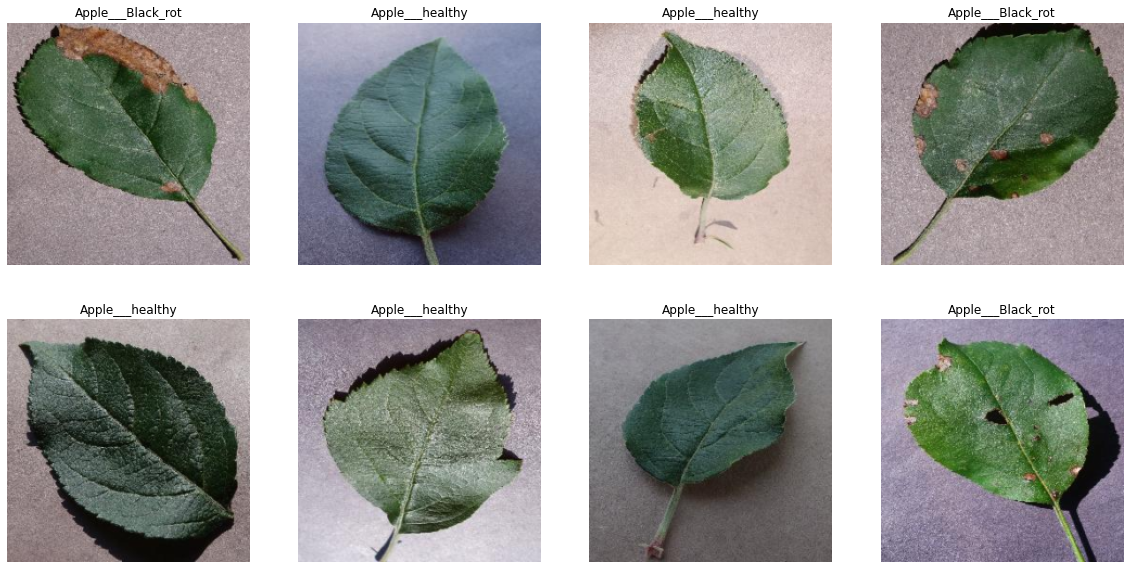

In [9]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

num_images = 8
sample_indices = random.sample(range(len(dataset)), num_images)
sample_images = [dataset[i][0] for i in sample_indices]
sample_labels = [dataset[i][1] for i in sample_indices]


plot_images(sample_images, sample_labels, class_names, mean, std, num_images=num_images)

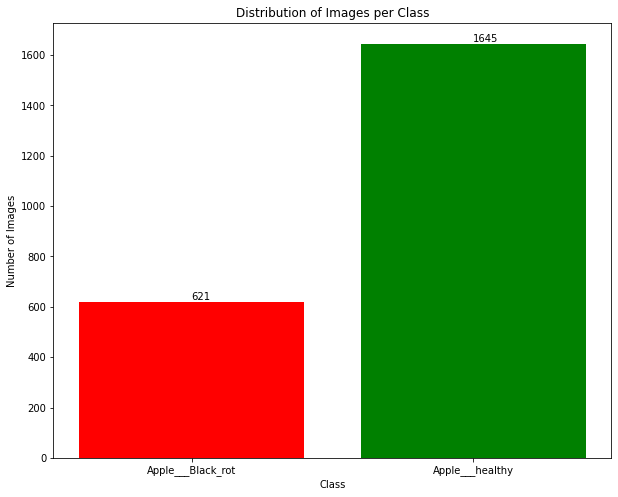

In [10]:
#Visualize the target distribution using a bar chart.
class_counts = [len(os.listdir(os.path.join(data_dir, class_name))) for class_name in class_names]

fig, ax = plt.subplots(figsize=(10, 8))
bars = ax.bar(class_names, class_counts, color=['red', 'green'])

for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom')

ax.set_title('Distribution of Images per Class')
ax.set_xlabel('Class')
ax.set_ylabel('Number of Images')

plt.show()

##### Sampling and Splitting Data
We randomly sample 100 images from each class to reduce computational load and split the data into training and testing sets (80% train, 20% test). 

In [11]:
# getting 100 images from each class
random.seed(42)
black_rot_sample = random.sample([i for i, (_, label) in enumerate(dataset) if label == class_indices['Apple___Black_rot']], 100)
healthy_sample = random.sample([i for i, (_, label) in enumerate(dataset) if label == class_indices['Apple___healthy']], 100)

#  a combined subset of selected 100 images from each classs
combined_indices = black_rot_sample + healthy_sample
subset = Subset(dataset, combined_indices)

In [12]:
# Splitting data into 80% train, 20% test
train_size = int(0.8 * len(subset))
test_size = len(subset) - train_size

# Spliting into train, test set
train_set, test_set = random_split(subset, [train_size, test_size])

In [13]:
train_size, test_size

(160, 40)

DataLoaders are created for the training and testing sets to facilitate batch processing during model training and evaluation. This allows efficient loading and shuffling of data.

In [14]:
# creating DataLoaders
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

In [15]:
models.VGG16_Weights.DEFAULT.transforms()

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

##### Load and Modify VGG-16 Model
We load the pre-trained VGG-16 model, remove the classifier, and freeze the feature extractor layers to prevent them from being updated during training. So, we will use these pre-trained features for our specific task.

In [16]:
#VGG-16 model
model=models.vgg16(weights="VGG16_Weights.DEFAULT") 
#VGG16_Weights.DEFAULT is equivalent to VGG16_Weights.IMAGENET1K_V1
#You can also use strings, e.g. weights='DEFAULT' or weights='IMAGENET1K_V1'.
features_extractor = model.features

# freezing the features of the model as no changes happen to its parameters
for param in features_extractor.parameters():
    param.requires_grad = False

##### Feature Extraction
A function is defined to extract features using the feature extractor of the VGG-16 model. Features are extracted for both training and testing sets. This step converts raw images into high-level features that can be used for classification.

In [17]:
def extract_features(data_loader, feature_extractor, device): #feature extractor as a model
    feature_extractor.eval()
    features = []
    labels = []

    with torch.no_grad():
        for inputs, label in data_loader:
            inputs = inputs.to(device)                   #move the batch of images to the dev
            outputs = feature_extractor(inputs)          #passing the images through the model to get the output features
            outputs = outputs.view(outputs.size(0), -1)  # flattening the features
            features.append(outputs.cpu())
            labels.append(label.cpu())

    return torch.cat(features), torch.cat(labels)

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
features_extractor = features_extractor.to(device)

In [19]:
# Extract features from the training set
train_features, train_labels = extract_features(train_loader, features_extractor, device)
# Extract features from the test set
test_features, test_labels = extract_features(test_loader, features_extractor, device)

In [20]:
train_features.shape  #25088=7x7x512
#each image in  training set is represented by a feature vector of length 25088

torch.Size([160, 25088])

In [21]:
features_extractor

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

##### Visualizing Feature Vectors
We plot a few feature vectors to visualize them. Each image in the training set is represented by a feature vector of length 25088. This helps in understanding the feature representation learned by the model.

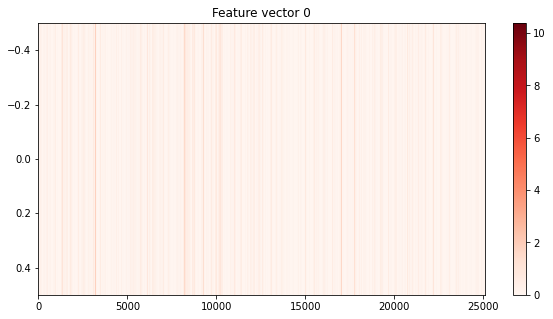

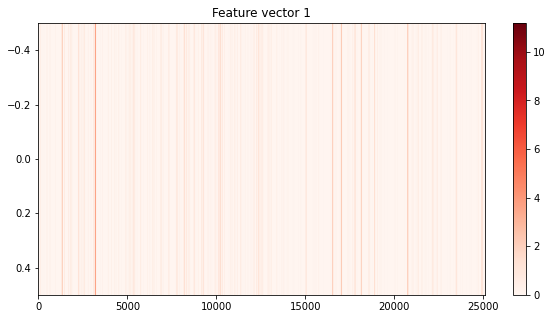

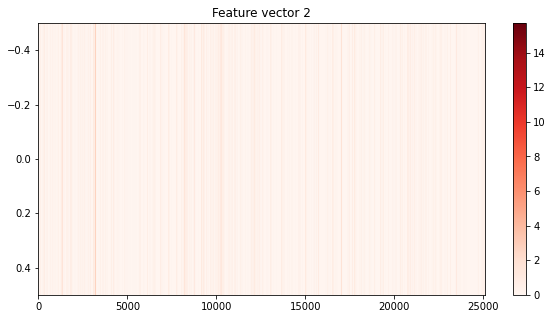

In [22]:
# Plotting a few feature vectors
for i in range(3):
    plt.figure(figsize=(10, 5))
    plt.imshow(train_features[i].unsqueeze(0).numpy(), cmap='Reds', aspect='auto')
    plt.colorbar()
    plt.title(f'Feature vector {i}')
    plt.show()

##### Calculating Mean Vectors and Discriminant Function
We then calculate the mean vectors for each class and compute the discriminant function to project the test data onto this direction. This helps in distinguishing between the two classes based on their feature representations.

In [23]:
# features by class seperation
C1_train = [train_features[i] for i in range(len(train_labels)) if train_labels[i] == class_indices['Apple___Black_rot']]
C2_train = [train_features[i] for i in range(len(train_labels)) if train_labels[i] == class_indices['Apple___healthy']]

# mean vectors on train set
mu1_train = torch.mean(torch.stack(C1_train, dim=0), dim=0)
mu2_train = torch.mean(torch.stack(C2_train, dim=0), dim=0)

In [26]:
mu1_train.shape

torch.Size([25088])

In [24]:
len(C1_train), len(C1_train[0])
#each image in set is represented by a feature vector of length 25088

(78, 25088)

In [25]:
len(C2_train), len(C2_train[0])

(82, 25088)

In [28]:
# the difference of means vector
w = mu2_train - mu1_train
# Normalizing the vector w
w = w / torch.norm(w)  

In [29]:
w.shape

torch.Size([25088])

In [32]:
25088/49

512.0

In [30]:
#building a the discriminant function which projects the train data on this direction
gx_test = torch.matmul(test_features, w)

In [31]:
gx_test.shape #pred for each image in test

torch.Size([40])

##### Evaluate the Model
We compute the ROC curve and determine the optimal threshold using Youden's J statistic for plotting decision boundary. 

In [29]:
# Computing the ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, gx_test)

# Computing the Youden's J statistic
j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold = thresholds[optimal_idx]

# the optimal threshold
print(f'Optimal threshold: {optimal_threshold}')

Optimal threshold: -22.813030242919922


##### Visualizing Class Separation
A scatter plot is created to visualize class separation using the discriminant function. Custom indices ensure that healthy instances start after black rot instances, making the plot easier to interpret.

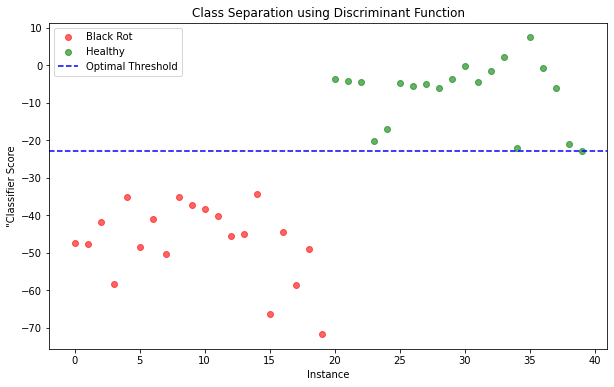

In [30]:
# Create custom indices for plotting
black_rot_indices = range(len(gx_test[test_labels == class_indices['Apple___Black_rot']]))
healthy_indices = range(len(black_rot_indices), len(black_rot_indices) + len(gx_test[test_labels == class_indices['Apple___healthy']]))

# Create a scatter plot
plt.figure(figsize=(10, 6))

# Plot points for each class with different colors
plt.scatter(black_rot_indices, 
            gx_test[test_labels == class_indices['Apple___Black_rot']], 
            color='red', label='Black Rot', alpha=0.6, marker='o')
plt.scatter(healthy_indices, 
            gx_test[test_labels == class_indices['Apple___healthy']], 
            color='green', label='Healthy', alpha=0.6, marker='o')

# Plot the horizontal line at the optimal threshold
plt.axhline(y=optimal_threshold, color='blue', linestyle='--', label='Optimal Threshold')

# Add labels and legend
plt.xlabel('Instance')
plt.ylabel('"Classifier Score')
plt.title('Class Separation using Discriminant Function')
plt.legend()
plt.show()


### ROC curve - AUC

We compute the ROC-AUC score and plot the ROC curve to evaluate the model's performance.

In [31]:
roc_auc = roc_auc_score(test_labels.numpy(), gx_test.numpy())

In [32]:
num_test_black_rot = (test_labels == class_indices['Apple___Black_rot']).sum().item()
num_test_healthy = (test_labels == class_indices['Apple___healthy']).sum().item()
print(f'Number of test instances - Black Rot: {num_test_black_rot}')
print(f'Number of test instances - Healthy: {num_test_healthy}')

Number of test instances - Black Rot: 20
Number of test instances - Healthy: 20


In [33]:
print(f'ROC-AUC: {roc_auc:.4f}')

ROC-AUC: 1.0000


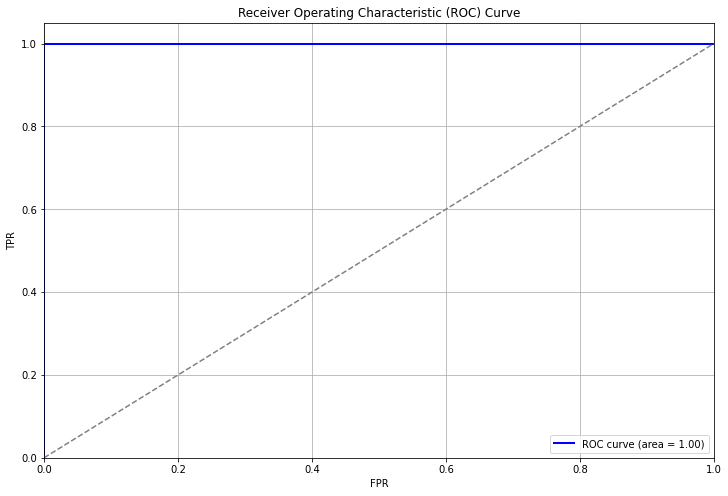

In [34]:
#  ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, gx_test)
# AUC
auc = roc_auc_score(test_labels, gx_test)
plt.figure(figsize=(12, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

### 4. Understanding the Image-Class Relation Pixel-Wise

In [35]:
# Define the path to the image file
sdir=r'Plant_leave_diseases_dataset_with_augmentation/Apple___Black_rot'
image_file_pth = os.path.join(sdir,  'image (50).JPG')

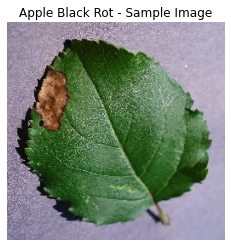

In [36]:
image = Image.open(image_file_pth)
plt.imshow(image)
plt.title('Apple Black Rot - Sample Image')
plt.axis('off')  
plt.show()

In [37]:
#random image from the dataset
flist=os.listdir(sdir)
test_img=random.choice(flist)
test_img_path=os.path.join(sdir, test_img)

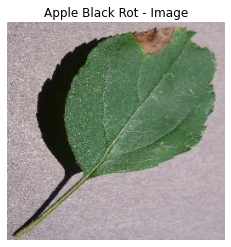

In [38]:
test_image = Image.open(test_img_path)
plt.imshow(test_image)
plt.title('Apple Black Rot - Image')
plt.axis('off')  
plt.show()

A function is defined to preprocess the image by resizing, converting to tensor, and normalizing it. This prepares the image for sensitivity analysis.

In [39]:
def preprocess_img(image_path):
    image = Image.open(image_path)
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    input_tensor = preprocess(image)
    input_tensor = input_tensor.unsqueeze(0)  
    return input_tensor

We compute gradients and importance scores for the input image to understand which pixels are most important for the prediction. This helps in identifying the regions of the image that contribute most to the classification decision.

In [40]:
def sensitivity_analysis(image_path, feature_extractor, w):
    input_tensor = preprocess_img(image_path)

    # Setting requires_grad=True to calculate gradients
    input_tensor.requires_grad_(True)

    # Forward pass through the feature extractor
    features = feature_extractor(input_tensor)
    features = features.view(features.size(0), -1)  # Flattening the features

    # Computing the custom classifier output
    output = torch.matmul(features, w)
    
    # Zero all existing gradients
    feature_extractor.zero_grad()
    input_tensor.grad = None

    # Backward pass to compute gradients
    output.backward()
    
    # Get the gradients of the input image
    gradients = input_tensor.grad.data
    
    #print(gradients.shape) #1x3x224x224
    #gradients = torch.autograd.grad(outputs=output, inputs=input_tensor, grad_outputs=torch.ones_like(output))[0]

    # Compute the importance scores 
    importance_scores = torch.sum(gradients ** 2, dim=1).squeeze().cpu().numpy()  #squared sum over channels
    
    #removing the importance scores lower than some level to reduce noise
    threshold = np.percentile(importance_scores, 20)  
    importance_scores[importance_scores < threshold] = 0
    
    # Normalizing the importance scores to [0, 1] range
    importance_scores = (importance_scores - np.min(importance_scores)) / (np.max(importance_scores) - np.min(importance_scores))
    
    return importance_scores

In [41]:
importance_scores = sensitivity_analysis(image_file_pth, features_extractor, w)

In [42]:
importance_scores

array([[0.        , 0.        , 0.00194342, ..., 0.        , 0.        ,
        0.        ],
       [0.00151967, 0.00042049, 0.00095557, ..., 0.00404612, 0.        ,
        0.        ],
       [0.0010116 , 0.01106852, 0.        , ..., 0.00504496, 0.00202493,
        0.00057157],
       ...,
       [0.00064877, 0.00213107, 0.00332325, ..., 0.00045361, 0.00127687,
        0.        ],
       [0.00048413, 0.        , 0.        , ..., 0.00072265, 0.00981615,
        0.        ],
       [0.        , 0.00185861, 0.        , ..., 0.00206263, 0.00085429,
        0.        ]], dtype=float32)

In [43]:
min_importance = np.min(importance_scores)
max_importance = np.max(importance_scores)

In [44]:
min_importance, max_importance #normalized 

(0.0, 1.0)

We defined a function to visualize the original image and its corresponding importance scores as a heatmap. 

In [45]:
def visualize_with_original(R, original_image):
    # the scaling factor
    b = 5 * ((np.abs(R) ** 3.0).mean() ** (1.0 / 3))
    
    # a custom colormap
    my_cmap = plt.cm.seismic(np.arange(plt.cm.seismic.N))
    my_cmap[:, 0:3] *= 0.95
    my_cmap = ListedColormap(my_cmap)


    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    #  the original image
    ax[0].imshow(original_image)
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    # the heatmap
    ax[1].imshow(R, cmap=my_cmap, vmin=-b, vmax=b)  
    ax[1].set_title('Heatmap')
    ax[1].axis('off')
    plt.show()

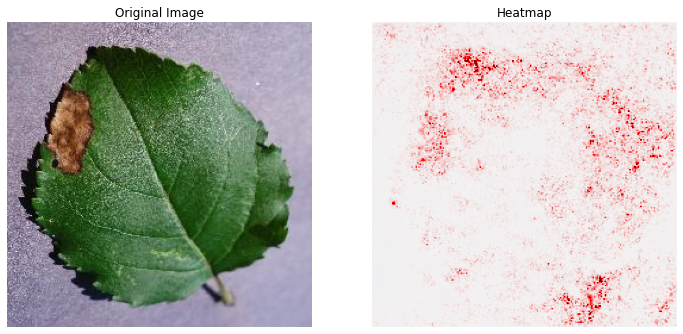

In [46]:
visualize_with_original(importance_scores, image)

##### Biased Layer for Robust Explanations
The `BiasedLayer` class is designed to create a modified layer that prioritizes excitatory effects over inhibitory effects. This is achieved by adding a positive bias to the weights and biases of the original layer. The class takes an existing layer (either convolutional or linear) and creates a modified version of it, where only the positive part of the weights and biases are increased.

So, the goal here is to enhance the robustness and interpretability of the model's explanations by making certain features more prominent.

**Functionality** ( how the BiasedLayer class works):
- `__init__`: Initializes the `BiasedLayer` with the original layer and creates a modified version of it.
- `_create_biased_layer`: Copies the original layer and adds a positive bias to its weights and biases.
- `forward`: Combines the outputs of the original and biased layers. Importantly, the division `(original_output / biased_output)` does not participate in the computation graph, meaning its gradients are not computed. This is achieved using the `.detach()` method, ensuring that this part does not affect backpropagation.

In [47]:
class BiasedLayer(nn.Module):
    def __init__(self, original_layer):
        super(BiasedLayer, self).__init__()
        # The original layer (conv or linear) that we want to modify.
        self.original_layer = original_layer  
        # A modified version of the original layer with biased weights and biases.
        self.biased_layer = self._create_biased_layer(original_layer)  


    def _create_biased_layer(self, layer):
        # Working on a copy to ensure we don't modify the original layer directly.
        biased_layer = copy.deepcopy(layer)  
        with torch.no_grad():
            if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
                # Only the positive part of the weights
                # biased towards excitatory effects.
                biased_layer.weight += 0.25 * torch.clamp(layer.weight, min=0)  
                if layer.bias is not None:
                    biased_layer.bias += 0.25 * torch.clamp(layer.bias, min=0)
        return biased_layer

    def forward(self, x):
        # Compute the output of the biased layer
        biased_output = self.biased_layer(x)
        # Compute the output of the original layer
        original_output = self.original_layer(x)
         # Combine the outputs, ensuring no gradient is computed for the (original_output / biased_output) part
        combined_output = biased_output *(original_output/biased_output).detach()
        return combined_output

##### Modify VGG-16 Model
We define a function to modify the VGG-16 model by applying the `BiasedLayer` to each convolutional and linear layer.

Therefore, the aim here is to incorporate the `BiasedLayer` into the network, making the model's explanations more robust and interpretable.

**Modification Process**:
- **Iteration**: The function iterates over each layer in the VGG-16 model's feature extractor.
- **Replacement**: For convolutional and linear layers (except the first and last layers), it replaces the original layer with a `BiasedLayer`.
- **Sequential**: The modified layers are combined into a new `Sequential` model, which becomes the new feature extractor of the VGG-16 model.


In [48]:
# function to modify VGG-16 model
def modify_vgg16(model):
    new_features = []
    for i, layer in enumerate(model.features):
        if (isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear)) and i != 0 and i != len(model.features) - 1:
            new_features.append(BiasedLayer(layer))
        else:
            new_features.append(layer)
    model.features = nn.Sequential(*new_features)
    return model

In [49]:
model_rob = modify_vgg16(model)
features_extractor = model_rob.features.to(device)

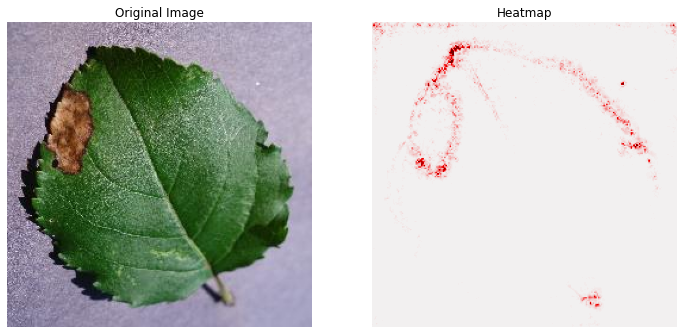

In [50]:
importance_scores_rob = sensitivity_analysis(image_file_pth, features_extractor, w)
visualize_with_original(importance_scores_rob, image)

We pass the input tensor through the features_extractor, which is the modified VGG-16 model's feature extractor.

In [51]:
#modified structure of the feature extractor 
features_extractor

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): BiasedLayer(
    (original_layer): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (biased_layer): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): BiasedLayer(
    (original_layer): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (biased_layer): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (6): ReLU(inplace=True)
  (7): BiasedLayer(
    (original_layer): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (biased_layer): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): BiasedLayer(
    (original_layer): Conv2

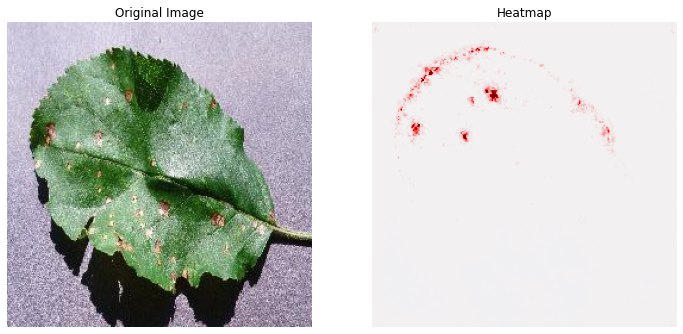

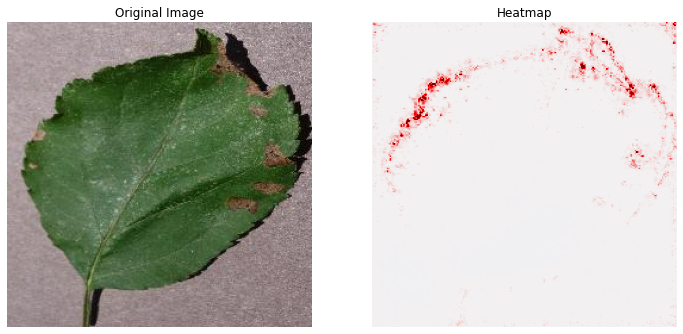

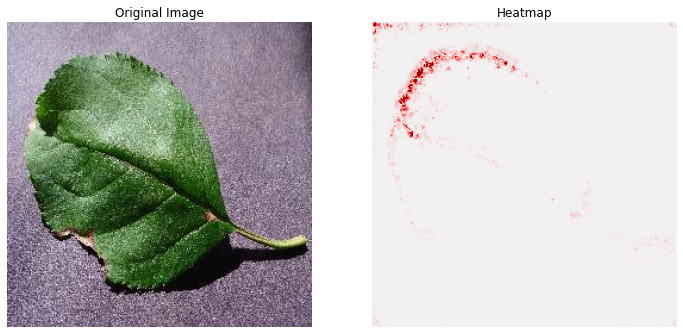

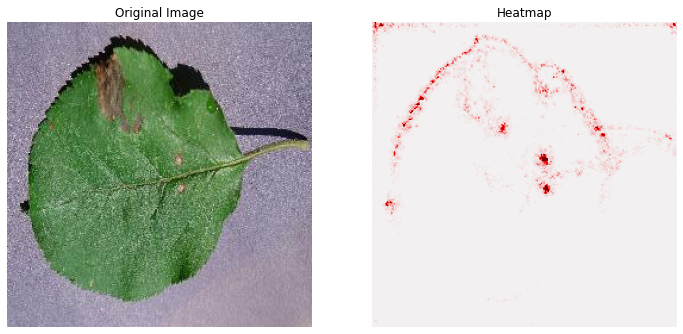

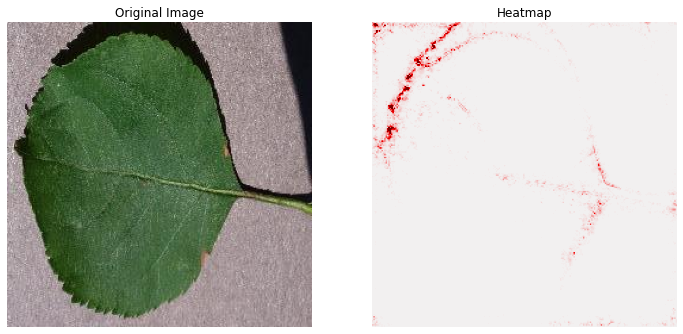

In [52]:
# Visualizing multiple ramdom samples with their explanation heatmap from black rot(diseased) class
sdir = r'Plant_leave_diseases_dataset_with_augmentation/Apple___Black_rot'
flist = os.listdir(sdir)
num_samples = 5  
sample_images = random.sample(flist, num_samples)

for img_name in sample_images:
    img_path = os.path.join(sdir, img_name)
    importance_scores = sensitivity_analysis(img_path, features_extractor, w)
    original_image = Image.open(img_path)
    visualize_with_original(importance_scores, original_image)

### 4.3 Discussion

In the examples above, we observe that the pixels highlighted as relevant do not accurately overlap with the region of the leaf where the disease is visible. This discrepancy can arise from several potential sources. Below, we discuss these issues and propose solutions to address them.

### 1. Regarding Explanation Method

**Gradient-Based Methods** for neural network explanations is generally noisy. This noise can obscure the true areas of interest in the image.

**Possible Solutions:**

To address this, more robust gradient-based methods such as SmoothGrad, Grad-CAM, or Integrated Gradients can be used. For example, **SmoothGrad** averages the gradients of several noisy versions of the input image, which helps to smooth out the noise and produce a clearer, more robust explanation. In the paper **'SmoothGrad: removing noise by adding noise' by Smilkov et al.**, it is shown that adding noise during training also improves the sharpness of sensitivity maps. Furthermore, combining both techniques — adding noise during training and inferring with noise yields the most visually coherent sensitivity maps, indicating that their effects are additive and produce better results together.

Moreover, we need to consider that as it is clear from formula
$ S_i(x) = \left( \frac{\partial g}{\partial x_i} \right)^2 $
, this sensitivity analysis method only analyzes variations in the decision function based on small perturbations in input pixels, without explaining the actual contribution of each feature to the prediction. In contrast,  **Layer-wise Relevance Propagation (LRP)** can be utilized as an alternative. LRP assigns relevance scores to each pixel by propagating the prediction score backward through the network layers, clearly indicating what in the input contributed to the output. This method considers the network's structure, offering more stable and interpretable explanations. 


### 2. Regarding Pretrained Model

The pretrained VGG-16 model used in our study was trained on the **ImageNet dataset**, which contains limited classes related to trees, leaves, or plants. This can lead to suboptimal performance for plant disease classification.

**Possible Solutions:**

- **Fine-Tuning the Model**: To address this, fine-tuning the model on a dataset specifically tailored to plant diseases can significantly improve its performance. Initially, the model should be fine-tuned on the given full dataset containing all 39 plant disease classes, followed by further training on the specific two classes of interest (black rot and healthy apple leaves).

- **Domain-Specific Pretrained Models**: Utilizing models ,for example, pretrained on  the PlantVillage dataset can also improve performance. These models, often based on architectures like ResNet or EfficientNet, have been specifically fine-tuned for plant disease detection and can provide a better starting point for our task.

- **Segmentation-Based Models**: Models such as U2-Net, which focus on identifying and segmenting diseased areas on leaves, might perform better. If we had a dataset where diseased areas were accurately labeled, these models could provide more precise and relevant explanations.

### 3.  Regarding Data Quality and Model Robustness

Analyzing the heatmaps of several diseased samples reveals that **edges and shadowed regions of leaf borders** are often highlighted, despite being **irrelevant to the disease**.

**Reasons for Irrelevant Highlights**:
1. **Edge Effects**: Borders and edges often have high gradient values due to abrupt changes in pixel values, causing these areas to be highlighted.
2. **Training Data Bias**: If the model has learned from many examples where the border or background had some indirect correlation with the disease, it might mistakenly consider these areas important.

**Possible Solutions**:
- **Consistent Image Standards**: Variability in background, lighting, and image quality can affect model performance. To minimize these effects, leaf parts can be extracted using border detection techniques (or bounding box of leaf), allowing the model to focus solely on the leaf for classification.
- **Augmented Backgrounds**: Alternative to the first solution, adding augmented versions of backgrounds to the training data can make the model more robust to changes in the background.
- **Additional Augmentation Techniques**: After extracting the leaf part, various augmentation techniques can be applied to consider all possible variations in the training dataset. Examples include:
  - **Rotation**: Randomly rotating the leaf images to simulate different orientations.
  - **Lighting Intensity Changes**: Adjusting the brightness, contrast, and saturation to account for different lighting conditions.
  - **Flipping**: Horizontally and vertically flipping the images to increase variability.
  - **Scaling and Cropping**: Randomly scaling and cropping parts of the leaf to simulate different zoom levels.
  - **Color Jittering**: Randomly changing the color properties to simulate different environmental conditions.


Moreover, we know that VGG-16 requires a standard input image size of 224x224 pixels. However, if we could use smaller image sizes with a different model, we could potentially improve robustness by adding blurring to these smaller images. This would help the model focus on the main parts of the image and produce clearer, more interpretable heatmaps with less irrelevant information, making it easier for humans to interpret the results.